In [25]:
import sys
sys.version_info
print(sys.version)

3.9.17 (main, Jun 20 2023, 17:20:08) 
[Clang 14.0.3 (clang-1403.0.22.14.1)]


In [26]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
print(keras.__version__)
import sklearn
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import wandb
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Sans'
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import random
from glob import glob
import IPython.display as ipd
from tqdm.notebook import tqdm
os.environ["WANDB_SILENT"] = "true"
import warnings
warnings.filterwarnings("ignore")
# Show less log messages
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

2.6.0


In [27]:
tf.config.list_physical_devices('GPU')
print(tf.test.is_gpu_available())

False


In [28]:
BASE_PATH = '/Users/morzahavi/Library/Mobile Documents/com~apple~CloudDocs/Downloads/asvspoof/LA'
FOLDS = 10
SEED = 101
DEBUG = True

# Audio params
SAMPLE_RATE = 16000
DURATION = 5.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = AUDIO_LEN//(SPEC_WIDTH - 1) # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape

In [29]:
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real
if DEBUG:
    train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Train Samples: {len(train_df)}')
train_df.head(2)

Train Samples: 5000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0089,LA_T_7429069,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0
1,LA_0080,LA_T_8739453,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0


In [30]:
valid_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt',
                       sep=" ", header=None)
valid_df.columns =['speaker_id','filename','system_id','null','class_name']
valid_df.drop(columns=['null'],inplace=True)
valid_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_dev/flac/'+valid_df.filename+'.flac'
valid_df['target'] = (valid_df.class_name=='spoof').astype('int32')
if DEBUG:
    valid_df = valid_df.groupby(['target']).sample(2000).reset_index(drop=True)
print(f'Valid Samples: {len(valid_df)}')
valid_df.head(2)

Valid Samples: 4000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0105,LA_D_3494648,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0
1,LA_0073,LA_D_9160310,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0


In [31]:
test_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt',
                      sep=" ", header=None)
test_df.columns =['speaker_id','filename','system_id','null','class_name']
test_df.drop(columns=['null'],inplace=True)
test_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_eval/flac/'+test_df.filename+'.flac'
test_df['target'] = (test_df.class_name=='spoof').astype('int32')
if DEBUG:
    test_df = test_df.groupby(['target']).sample(2000).reset_index(drop=True)
print(f'Test Samples: {len(test_df)}')
test_df.head(2)

Test Samples: 4000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0043,LA_E_2825647,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0
1,LA_0057,LA_E_6296442,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0


In [32]:
def load_audio(path, sr=16000):
    """load audio from .wav file
    Args:
        path: file path of .wav file
        sr: sample rate
    Returns:
        audio, sr
    """
    audio, sr = librosa.load(path, sr=sr)
    return audio, sr

def plot_audio(audio, sr=16000):
    fig = librosa.display.waveshow(audio,
                                   x_axis='time',
                                   sr=sr)
    return fig

def listen_audio(audio, sr=16000):
    display(ipd.Audio(audio, rate=sr))

def get_spec(audio):
    spec = librosa.feature.melspectrogram(audio, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)
    return spec

def plot_spec(spec, sr=16000):
    fig = librosa.display.specshow(spec,
                                   x_axis='time',
                                   y_axis='hz',
                                   hop_length=HOP_LEN,
                                   sr=SAMPLE_RATE,
                                   fmax=FMAX,)
    return fig

> Filename: LA_T_2797155 | Label: bonafide
# Listen


# Plot



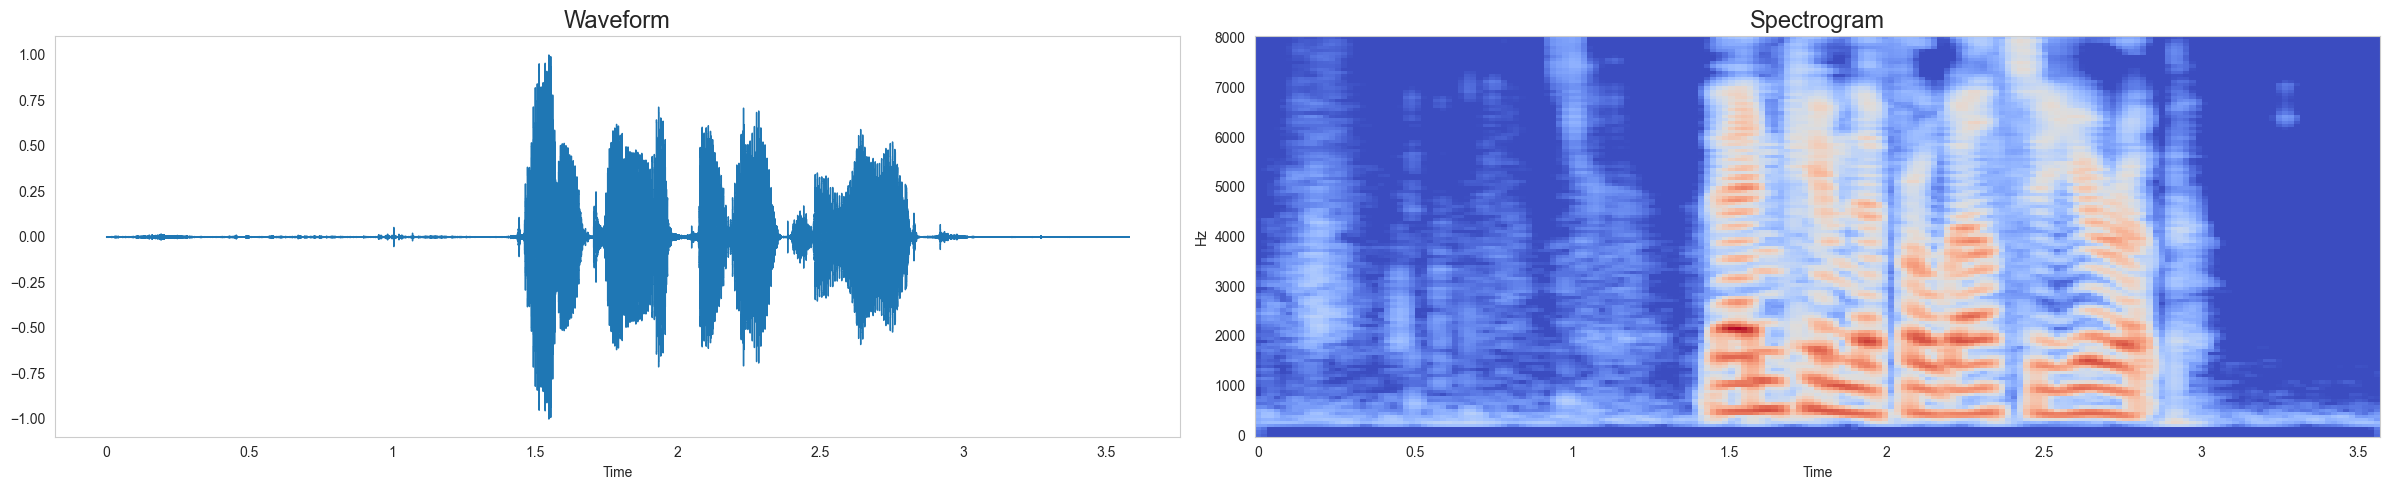

In [111]:
row = train_df[train_df.target==0].iloc[10]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))




fig = plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)


plt.subplot(122)
plot_spec(spec);
plt.title("Spectrogram",fontsize=17)

#
# aspect_ratio = 10
# width = 8.0
# height = width / aspect_ratio
plt.tight_layout()
plt.savefig('wave_spect')

plt.tight_layout()
plt.show()





In [34]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Split train data into folds
for fold, (_, val_idx) in enumerate(skf.split(train_df, y=train_df['target'])):
    train_df.loc[val_idx, 'fold'] = fold

# Split valid data into folds
for fold, (_, val_idx) in enumerate(skf.split(valid_df, y=valid_df['target'])):
    valid_df.loc[val_idx, 'fold'] = fold

# Split test data into folds
for fold, (_, val_idx) in enumerate(skf.split(test_df, y=test_df['target'])):
    test_df.loc[val_idx, 'fold'] = fold
display(test_df.groupby(['fold','target']).size())

fold  target
0.0   0         200
      1         200
1.0   0         200
      1         200
2.0   0         200
      1         200
3.0   0         200
      1         200
4.0   0         200
      1         200
5.0   0         200
      1         200
6.0   0         200
      1         200
7.0   0         200
      1         200
8.0   0         200
      1         200
9.0   0         200
      1         200
dtype: int64

In [35]:
train_df.fold.value_counts()

9.0    500
0.0    500
1.0    500
4.0    500
7.0    500
3.0    500
5.0    500
8.0    500
6.0    500
2.0    500
Name: fold, dtype: int64

In [36]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [37]:
def train_serialize_example(feature0, feature1, feature2,
                            feature3, feature4,feature5,feature6):
    feature = {
        'audio':_bytes_feature(feature0),
        'id':_bytes_feature(feature1),
        'speaker_id':_bytes_feature(feature2),
        'system_id':_bytes_feature(feature3),
        'class_name':_bytes_feature(feature4),
        'audio_len':_int64_feature(feature5),
        'target':_int64_feature(feature6),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [38]:
os.makedirs('/tmp/asvspoof', exist_ok=True)

In [39]:
def write_tfrecord(df, split='train', show=True):
    df = df.copy()
    folds = sorted(df.fold.unique().tolist())
    for fold in tqdm(folds): # create tfrecord for each fold
        fold_df = df.query("fold==@fold").sample(frac=1.0)
        if show:
            print(); print('Writing %s TFRecord of fold %i :'%(split,fold))
        with tf.io.TFRecordWriter('/tmp/asvspoof/%s%.2i-%i.tfrec'%(split,fold,fold_df.shape[0])) as writer:
            samples = fold_df.shape[0] # samples = 200
            it = tqdm(range(samples)) if show else range(samples)
            for k in it: # images in fold
                row = fold_df.iloc[k,:]
                audio, sr = load_audio(row['filepath'])
                audio_id = row['filename']
                speaker_id = row['speaker_id']
                system_id = row['system_id']
                class_name = row['class_name']
                target = row['target']
                example  = train_serialize_example(
                    tf.audio.encode_wav(audio[...,None],sample_rate=sr),
                    str.encode(audio_id),
                    str.encode(speaker_id),
                    str.encode(system_id),
                    str.encode(class_name),
                    len(audio),
                    int(target),
                )
                writer.write(example)
            if show:
                filepath = '/tmp/asvspoof/%s%.2i-%i.tfrec'%(split,fold,fold_df.shape[0])
                filename = filepath.split('/')[-1]
                filesize = os.path.getsize(filepath)/10**6
                print(filename,':',np.around(filesize, 2),'MB')

In [40]:
# write_tfrecord(train_df,split='train', show=True)

In [41]:
# write_tfrecord(valid_df,split='valid', show=True)

In [42]:
# write_tfrecord(test_df,split='test', show=True)

In [43]:
import re, math
def decode_audio(data, audio_len, target_len=1*16000):
    audio, sr = tf.audio.decode_wav(data)
    audio = tf.reshape(audio, [audio_len]) # explicit size needed for TPU
    audio = audio[:target_len]
    audio = tf.cast(audio,tf.float32)
    # compute min and max
    min_ = tf.reduce_min(audio)
    max_ = tf.reduce_max(audio)
    # normalization
    audio = (audio - min_) / (max_ - min_) # mean=0 & std=1
    return audio

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "audio" : tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "audio_len" : tf.io.FixedLenFeature([], tf.int64),
        "target" : tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    audio_len = example['audio_len']
    audio = decode_audio(example['audio'], audio_len)
    target = example['target']
    return audio, target  # returns a dataset of (image, label) pairs

def load_dataset(fileids, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(fileids, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_dataset(FILENAMES):
    dataset = load_dataset(FILENAMES, labeled=True)
    #     dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(100, seed=SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(fileids):
    # the number of data items is written in the id of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) for fileid in fileids]
    return np.sum(n)

In [44]:
def display_batch(batch, row=2, col=5):
    audios, targets = batch
    plt.figure(figsize=(col*5, 5*row))
    for idx in range(row*col):
        audio = audios[idx,]
        target = targets[idx,]
        plt.subplot(row, col, idx+1)
        plt.plot(audio, color='r' if target else 'b')
        plt.title('Fake' if target else 'Real', fontsize=15)
    #         plt.xticks([])
    #         plt.yticks([])
    plt.tight_layout()
    plt.show()#%%
import os
import shutil
import pandas as pd
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [45]:
# BASE_PATH = '~/icloud/Downloads/asvspoof/LA'
FOLDS = 10
SEED = 101
DEBUG = True

# Audio params
SAMPLE_RATE = 16000
DURATION = 5.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = AUDIO_LEN//(SPEC_WIDTH - 1) # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape

In [46]:
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real
if DEBUG:
    train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Train Samples: {len(train_df)}')
train_df.head(2)

Train Samples: 5000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0081,LA_T_7337587,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0
1,LA_0089,LA_T_3304535,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0


In [47]:
valid_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt',
                       sep=" ", header=None)
valid_df.columns =['speaker_id','filename','system_id','null','class_name']
valid_df.drop(columns=['null'],inplace=True)
valid_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_dev/flac/'+valid_df.filename+'.flac'
valid_df['target'] = (valid_df.class_name=='spoof').astype('int32')
if DEBUG:
    valid_df = valid_df.groupby(['target']).sample(2000).reset_index(drop=True)
print(f'Valid Samples: {len(valid_df)}')
valid_df.head(2)

Valid Samples: 4000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0105,LA_D_5567251,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0
1,LA_0077,LA_D_8017985,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0


In [48]:
test_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt',
                      sep=" ", header=None)
test_df.columns =['speaker_id','filename','system_id','null','class_name']
test_df.drop(columns=['null'],inplace=True)
test_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_eval/flac/'+test_df.filename+'.flac'
test_df['target'] = (test_df.class_name=='spoof').astype('int32')
if DEBUG:
    test_df = test_df.groupby(['target']).sample(2000).reset_index(drop=True)
print(f'Test Samples: {len(test_df)}')
test_df.head(2)

Test Samples: 4000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0051,LA_E_4189757,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0
1,LA_0041,LA_E_1485085,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0


In [49]:
def load_audio(path, sr=16000):
    """load audio from .wav file
    Args:
        path: file path of .wav file
        sr: sample rate
    Returns:
        audio, sr
    """
    audio, sr = librosa.load(path, sr=sr)
    return audio, sr

def plot_audio(audio, sr=16000):
    fig = librosa.display.waveshow(audio,
                                   x_axis='time',
                                   sr=sr)
    return fig

def listen_audio(audio, sr=16000):
    display(ipd.Audio(audio, rate=sr))

def get_spec(audio):
    spec = librosa.feature.melspectrogram(audio, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)
    return spec

def plot_spec(spec, sr=16000):
    fig = librosa.display.specshow(spec,
                                   x_axis='time',
                                   y_axis='hz',
                                   hop_length=HOP_LEN,
                                   sr=SAMPLE_RATE,
                                   fmax=FMAX,)
    return fig

In [50]:
# listen_audio(LA_T_3685206.flac)

> Filename: LA_T_8220892 | Label: bonafide
# Listen


# Plot



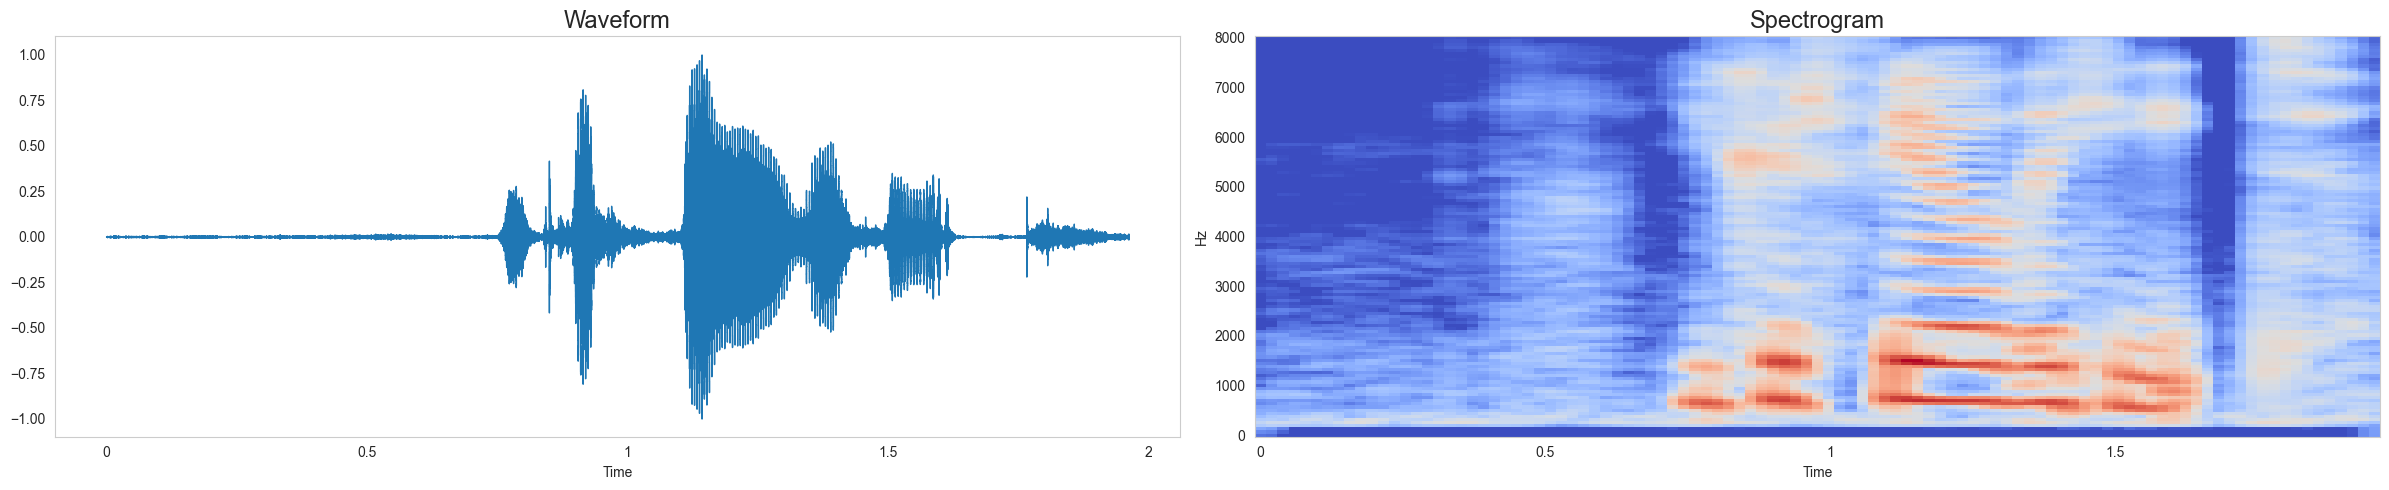

In [51]:
row = train_df[train_df.target==0].iloc[10]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(122)
plot_spec(spec);
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

In [52]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Split train data into folds
for fold, (_, val_idx) in enumerate(skf.split(train_df, y=train_df['target'])):
    train_df.loc[val_idx, 'fold'] = fold

# Split valid data into folds
for fold, (_, val_idx) in enumerate(skf.split(valid_df, y=valid_df['target'])):
    valid_df.loc[val_idx, 'fold'] = fold

# Split test data into folds
for fold, (_, val_idx) in enumerate(skf.split(test_df, y=test_df['target'])):
    test_df.loc[val_idx, 'fold'] = fold
display(test_df.groupby(['fold','target']).size())

fold  target
0.0   0         200
      1         200
1.0   0         200
      1         200
2.0   0         200
      1         200
3.0   0         200
      1         200
4.0   0         200
      1         200
5.0   0         200
      1         200
6.0   0         200
      1         200
7.0   0         200
      1         200
8.0   0         200
      1         200
9.0   0         200
      1         200
dtype: int64

In [53]:
train_df.fold.value_counts()

9.0    500
0.0    500
1.0    500
4.0    500
7.0    500
3.0    500
5.0    500
8.0    500
6.0    500
2.0    500
Name: fold, dtype: int64

In [54]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [55]:
def train_serialize_example(feature0, feature1, feature2,
                            feature3, feature4,feature5,feature6):
    feature = {
        'audio':_bytes_feature(feature0),
        'id':_bytes_feature(feature1),
        'speaker_id':_bytes_feature(feature2),
        'system_id':_bytes_feature(feature3),
        'class_name':_bytes_feature(feature4),
        'audio_len':_int64_feature(feature5),
        'target':_int64_feature(feature6),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [56]:
os.makedirs('/tmp/asvspoof', exist_ok=True)

In [57]:
def write_tfrecord(df, split='train', show=True):
    df = df.copy()
    folds = sorted(df.fold.unique().tolist())
    for fold in tqdm(folds): # create tfrecord for each fold
        fold_df = df.query("fold==@fold").sample(frac=1.0)
        if show:
            print(); print('Writing %s TFRecord of fold %i :'%(split,fold))
        with tf.io.TFRecordWriter('/tmp/asvspoof/%s%.2i-%i.tfrec'%(split,fold,fold_df.shape[0])) as writer:
            samples = fold_df.shape[0] # samples = 200
            it = tqdm(range(samples)) if show else range(samples)
            for k in it: # images in fold
                row = fold_df.iloc[k,:]
                audio, sr = load_audio(row['filepath'])
                audio_id = row['filename']
                speaker_id = row['speaker_id']
                system_id = row['system_id']
                class_name = row['class_name']
                target = row['target']
                example  = train_serialize_example(
                    tf.audio.encode_wav(audio[...,None],sample_rate=sr),
                    str.encode(audio_id),
                    str.encode(speaker_id),
                    str.encode(system_id),
                    str.encode(class_name),
                    len(audio),
                    int(target),
                )
                writer.write(example)
            if show:
                filepath = '/tmp/asvspoof/%s%.2i-%i.tfrec'%(split,fold,fold_df.shape[0])
                filename = filepath.split('/')[-1]
                filesize = os.path.getsize(filepath)/10**6
                print(filename,':',np.around(filesize, 2),'MB')

In [58]:
# write_tfrecord(train_df,split='train', show=True)

In [59]:
# write_tfrecord(valid_df,split='valid', show=True)

In [60]:
# write_tfrecord(test_df,split='test', show=True)

In [61]:
import re, math
def decode_audio(data, audio_len, target_len=1*16000):
    audio, sr = tf.audio.decode_wav(data)
    audio = tf.reshape(audio, [audio_len]) # explicit size needed for TPU
    audio = audio[:target_len]
    audio = tf.cast(audio,tf.float32)
    # compute min and max
    min_ = tf.reduce_min(audio)
    max_ = tf.reduce_max(audio)
    # normalization
    audio = (audio - min_) / (max_ - min_) # mean=0 & std=1
    return audio

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "audio" : tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "audio_len" : tf.io.FixedLenFeature([], tf.int64),
        "target" : tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    audio_len = example['audio_len']
    audio = decode_audio(example['audio'], audio_len)
    target = example['target']
    return audio, target  # returns a dataset of (image, label) pairs

def load_dataset(fileids, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(fileids, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_dataset(FILENAMES):
    dataset = load_dataset(FILENAMES, labeled=True)
    #     dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(100, seed=SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(fileids):
    # the number of data items is written in the id of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) for fileid in fileids]
    return np.sum(n)

In [62]:
def display_batch(batch, row=2, col=5):
    audios, targets = batch
    plt.figure(figsize=(col*5, 5*row))
    for idx in range(row*col):
        audio = audios[idx,]
        target = targets[idx,]
        plt.subplot(row, col, idx+1)
        plt.plot(audio, color='r' if target else 'b')
        plt.title('Fake' if target else 'Real', fontsize=15)
    #         plt.xticks([])
    #         plt.yticks([])
    plt.tight_layout()
    plt.show()

In [63]:
    BATCH_SIZE = 32
    AUTO = tf.data.experimental.AUTOTUNE
    TRAIN_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/train*.tfrec')
    VALID_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/valid*.tfrec')
    TEST_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/test*.tfrec')
    print('There are %i train, %i valid & %i test images'%(count_data_items(TRAIN_FILENAMES),
                                                           count_data_items(VALID_FILENAMES),
                                                           count_data_items(TEST_FILENAMES)))

There are 5000 train, 4000 valid & 4000 test images


2023-07-24 13:02:00.099121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


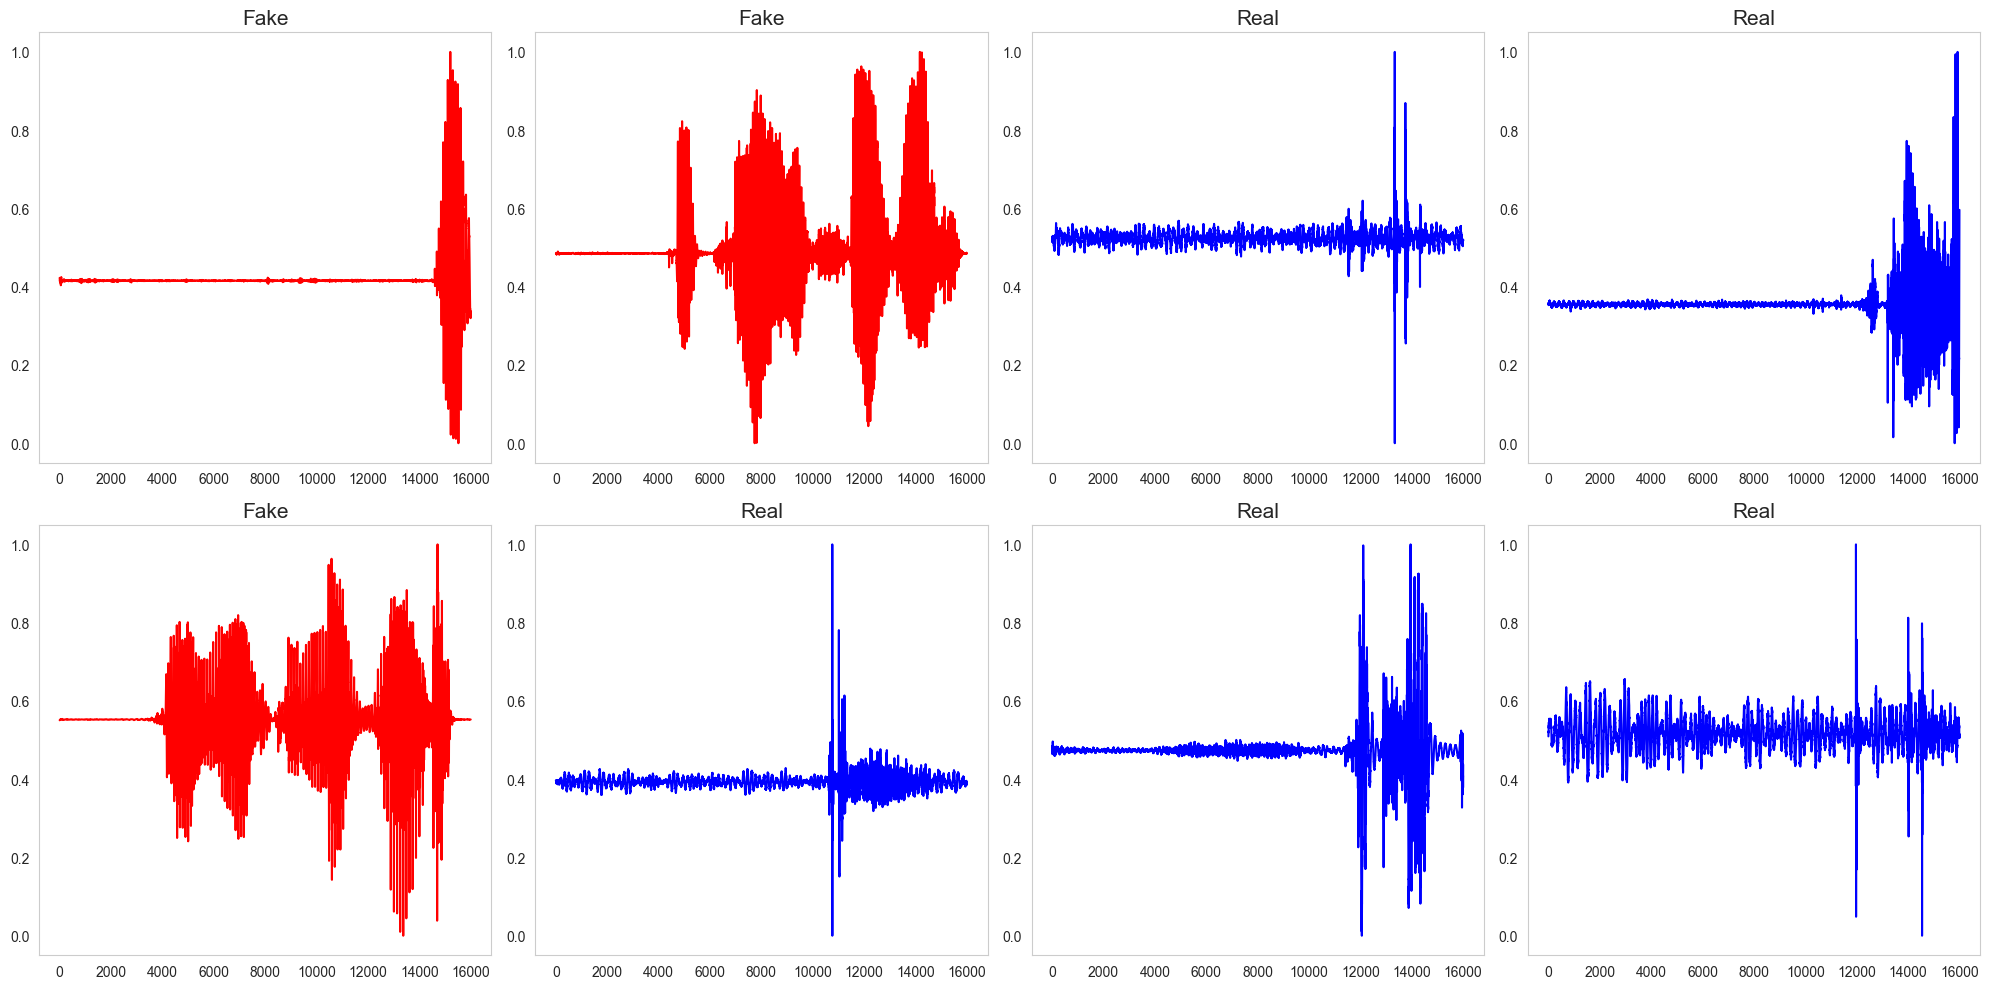

In [64]:
# Display Batch Images
ds = get_dataset(TRAIN_FILENAMES)
batch = next(iter(ds))
display_batch(batch, row=2, col=4);

In [65]:
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAIN_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/train*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/valid*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/test*.tfrec')
print('There are %i train, %i valid & %i test images'%(count_data_items(TRAIN_FILENAMES),
                                                       count_data_items(VALID_FILENAMES),
                                                       count_data_items(TEST_FILENAMES)))

There are 5000 train, 4000 valid & 4000 test images


In [66]:
class CFG:
    wandb = True
    project = "fake-speech-detection"
    debug = False
    exp_name = "v0"
    comment = "Conformer-128x80-cosine-no_aug-no_fc"

    # Use verbose=0 for silent, 1 for interactive
    verbose = 0
    display_plot = True

    # Device for training
    device = None  # device is automatically selected

    # Model & Backbone
    model_name = "Conformer"

    # Seeding for reproducibility
    seed = 101

    # Audio params
    sample_rate = 16000
    duration = 3.5 # duration in second
    audio_len = int(sample_rate * duration)
    normalize = True

    # Spectrogram params
    spec_freq = 128 # freq axis
    n_fft = 2048
    spec_time = 256 # time axis
    hop_len = audio_len//(spec_time - 1) # non-overlap region
    fmin = 20
    fmax = sample_rate//2 # max frequency
    spec_shape = [spec_time, spec_freq] # output spectrogram shape

    # Audio Augmentation
    timeshift_prob = 0.0
    gn_prob = 0.0

    # Spectrogram Augmentation
    time_mask = 20
    freq_mask = 10
    cutmix_prob = 0.0
    cutmix_alpha = 2.5
    mixup_prob = 0.0
    mixup_alpha = 2.5

    # Batch Size & Epochs
    batch_size = 32
    drop_remainder = False
    epochs = 12
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "binary_crossentropy"
    optimizer = "Adam"
    lr = 1e-4
    lr_schedule = "cosine"

    # Augmentation
    augment = False

    # Clip values to [0, 1]
    clip = False

In [67]:
def seeding(SEED):
    """
    Sets all random seeds for the program (Python, NumPy, and TensorFlow).
    """
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    #     os.environ["TF_CUDNN_DETERMINISTIC"] = str(SEED)
    tf.random.set_seed(SEED)
    print("seeding done!!!")


seeding(CFG.seed)

seeding done!!!


In [68]:
def configure_device():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # connect to tpu cluster
        strategy = tf.distribute.TPUStrategy(tpu) # get strategy for tpu
        print('> Running on TPU ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device='TPU'
    except: # otherwise detect GPUs
        tpu = None
        gpus = tf.config.list_logical_devices('GPU') # get logical gpus
        ngpu = len(gpus)
        if ngpu: # if number of GPUs are 0 then CPU
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy() # connect to single gpu or cpu
            device='CPU'
    return strategy, device, tpu

In [69]:
strategy, CFG.device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

> Running on CPU
REPLICAS: 1


In [70]:
BASE_PATH = '/Users/morzahavi/Library/Mobile Documents/com~apple~CloudDocs/Downloads/asvspoof/LA'

# Train
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real
if True:
    train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Train Samples: {len(train_df)}')
train_df.head(2)

Train Samples: 5000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_6200206,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0
1,LA_0085,LA_T_6638771,-,bonafide,/Users/morzahavi/Library/Mobile Documents/com~...,0


In [71]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

In [72]:
# Trim Audio to ignore silent part in the start and end
def TrimAudio(audio, epsilon=0.15):
    pos  = tfio.audio.trim(audio, axis=0, epsilon=epsilon)
    audio = audio[pos[0]:pos[1]]
    return audio

# Crop or Pad audio to keep a fixed length
def CropOrPad(audio, target_len, pad_mode='constant'):
    audio_len = tf.shape(audio)[0]
    if audio_len < target_len: # if audio_len is smaller than target_len then use Padding
        diff_len = (target_len - audio_len)
        pad1 = random_int([], minval=0, maxval=diff_len) # select random location for padding
        pad2 = diff_len - pad1
        pad_len = [pad1, pad2]
        audio = tf.pad(audio, paddings=[pad_len], mode=pad_mode) # apply padding
    elif audio_len > target_len:  # if audio_len is larger than target_len then use Cropping
        diff_len = (audio_len - target_len)
        idx = tf.random.uniform([], 0, diff_len, dtype=tf.int32) # select random location for cropping
        audio = audio[idx: (idx + target_len)]
    audio = tf.reshape(audio, [target_len])
    return audio

# Randomly shift audio -> any sound at <t> time may get shifted to <t+shift> time
def TimeShift(audio, prob=0.5):
    if random_float() < prob:
        shift = random_int(shape=[], minval=0, maxval=tf.shape(audio)[0])
        if random_float() < 0.5:
            shift = -shift
        audio = tf.roll(audio, shift, axis=0)
    return audio

# Apply random noise to audio data
def GaussianNoise(audio, std=[0.0025, 0.025], prob=0.5):
    std = random_float([], std[0], std[1])
    if random_float() < prob:
        GN = tf.keras.layers.GaussianNoise(stddev=std)
        audio = GN(audio, training=True) # training=False don't apply noise to data
    return audio

# Applies augmentation to Audio Signal
def AudioAug(audio):
    audio = TimeShift(audio, prob=CFG.timeshift_prob)
    audio = GaussianNoise(audio, prob=CFG.gn_prob)
    return audio

def Normalize(data):
    MEAN = tf.math.reduce_mean(data)
    STD = tf.math.reduce_std(data)
    data = tf.math.divide_no_nan(data - MEAN, STD)
    return data

In [73]:
# Randomly mask data in time and freq axis
def TimeFreqMask(spec, time_mask, freq_mask, prob=0.5):
    if random_float() < prob:
        spec = tfio.audio.freq_mask(spec, param=freq_mask)
        spec = tfio.audio.time_mask(spec, param=time_mask)
    return spec

# Applies augmentation to Spectrogram
def SpecAug(spec):
    spec = TimeFreqMask(spec, time_mask=CFG.time_mask, freq_mask=CFG.freq_mask, prob=0.5)
    return spec

# Compute MixUp Augmentation for Spectrogram
def get_mixup(alpha=0.2, prob=0.5):
    """Apply Spectrogram-MixUp augmentaiton. Apply Mixup to one batch and its shifted version"""
    def mixup(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels

        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)

        beta = tfp.distributions.Beta(alpha, alpha) # select lambda from beta distribution
        lam = beta.sample(1)[0]

        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs = lam * specs + (1 - lam) * tf.roll(specs, shift=1, axis=0) # mixup = [1, 2, 3]*lam + [3, 1, 2]*(1 - lam)
        labels = lam * labels + (1 - lam) * tf.roll(labels, shift=1, axis=0)

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)
        return specs, labels
    return mixup


def get_cutmix(alpha, prob=0.5):
    """Apply Spectrogram-CutMix augmentaiton which only cuts patch across time axis unline
    typical Computer-Vision CutMix. Apply CutMix to one batch and its shifted version.
    """
    def cutmix(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels
        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)
        W = tf.cast(spec_shape[1], tf.int32)  # [batch, time, freq, channel]

        # Lambda from beta distribution
        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]

        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs_rolled = tf.roll(specs, shift=1, axis=0) # specs->[1, 2, 3], specs_rolled->[3, 1, 2]
        labels_rolled = tf.roll(labels, shift=1, axis=0)

        # Select random patch size
        r_x = random_int([], minval=0, maxval=W)
        r = 0.5 * tf.math.sqrt(1.0 - lam)
        r_w_half = tf.cast(r * tf.cast(W, tf.float32), tf.int32)

        # Select random location in time axis
        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, W), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, W), tf.int32)

        # outer-pad patch -> [0, 0, x, x, 0, 0]
        patch1 = specs[:, x1:x2, :, :]  # [batch, time, freq, channel]
        patch1 = tf.pad(
            patch1, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad

        # inner-pad-patch -> [y, y, 0, 0, y, y]
        patch2 = specs_rolled[:, x1:x2, :, :]  # [batch, mel, time, channel]
        patch2 = tf.pad(
            patch2, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad
        patch2 = specs_rolled - patch2  # inner-pad-patch = img - outer-pad-patch

        # patch1 -> [0, 0, x, x, 0, 0], patch2 -> [y, y, 0, 0, y, y]
        # cutmix = (patch1 + patch2) -> [y, y, x, x, y, y]
        specs = patch1 + patch2  # cutmix img

        # Compute lambda = [1 - (patch_area/image_area)]
        lam = tf.cast((1.0 - (x2 - x1) / (W)),tf.float32)  # no H term as (y1 - y2) = H
        labels = lam * labels + (1.0 - lam) * labels_rolled  # cutmix label

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)

        return specs, labels
    return cutmix

In [74]:
# Compute Spectrogram from audio
def Audio2Spec(audio,spec_shape=[256, 128],sr=16000,nfft=2048,window=2048,fmin=20,fmax=8000):
    spec_time = spec_shape[0]
    spec_freq = spec_shape[1]
    audio_len = tf.shape(audio)[0]
    hop_length = tf.cast((audio_len // (spec_time - 1)), tf.int32) # compute hop_length to keep desired spec_shape
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length) # convert to spectrogram
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_freq, fmin=fmin, fmax=fmax) # transform to melscale
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80) # from power to db (log10) scale
    if tf.shape(db_mel_spec)[0] > spec_time:  # check if we have desiered shape
        db_mel_spec = db_mel_spec[:spec_time,:]
    db_mel_spec = tf.reshape(db_mel_spec, spec_shape)
    return db_mel_spec

# Convert spectrogram (H,W) to image (H,W,1)
def Spec2Img(spec, num_channels=1):
    # 1 channel image
    img = spec[..., tf.newaxis]
    # Copy same image across channel axis
    if num_channels>1:
        img = tf.tile(img, [1, 1, num_channels])
    return img

In [75]:
# Decode audio from wav
def decode_audio(data, audio_len):
    # Decode
    audio, sr = tf.audio.decode_wav(data)
    audio = tf.reshape(audio, [audio_len]) # explicit size needed for TPU
    audio = tf.cast(audio,tf.float32)
    # Normalization
    if CFG.normalize:
        audio = Normalize(audio)
    return audio

# Decode label
def decode_label(label):
    label = tf.cast(label, tf.float32)
    return label

# Read tfrecord data & parse it & do augmentation
def read_tfrecord(example, augment=True, return_id=False, return_label=True, target_len=CFG.audio_len, spec_shape=CFG.spec_shape):
    tfrec_format = {
        "audio" : tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id" : tf.io.FixedLenFeature([], tf.string),
        "speaker_id": tf.io.FixedLenFeature([], tf.string),
        "system_id" : tf.io.FixedLenFeature([], tf.string),
        "audio_len" : tf.io.FixedLenFeature([], tf.int64),
        "target" : tf.io.FixedLenFeature([], tf.int64),
    }
    # Parses a single example proto.
    example = tf.io.parse_single_example(
        example, tfrec_format
    )
    # Extract data from example proto
    audio_id = example["id"]
    audio_len = example["audio_len"]
    # Decoding
    audio = decode_audio(example["audio"], audio_len)  # decode audio from .wav
    target = decode_label(example["target"]) # decode label -> type cast
    # Trim Audio
    audio = TrimAudio(audio)
    # Crop or Pad audio to keep a fixed length
    audio = CropOrPad(audio, target_len)
    if augment:
        # Apply AudioAug
        audio = AudioAug(audio)
    # Compute Spectrogram
    spec = Audio2Spec(audio, spec_shape=spec_shape)
    if augment:
        # Apply SpecAug
        spec = SpecAug(spec)
    # Spectrogram (H, W) to Image (H, W, C)
    img = Spec2Img(spec, num_channels=1)
    # Clip & Reshape
    img = tf.clip_by_value(img, 0, 1) if CFG.clip else img
    img = tf.reshape(img, [*spec_shape, 1])

    if not return_id:
        if return_label:
            return (img, target)
        else:
            return img
    else:
        if return_label:
            return (img, target, audio_id)
        else:
            return (img, audio_id)

In [76]:
def get_dataset(
        filenames,
        shuffle=True,
        repeat=True,
        augment=True,
        cache=True,
        return_id=False,
        return_label=True,
        batch_size=CFG.batch_size * REPLICAS,
        target_len=CFG.audio_len,
        spec_shape=CFG.spec_shape,
        drop_remainder=False,
        seed=CFG.seed,
):
    # Real tfrecord files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if cache:
        dataset = dataset.cache()  # cache data for speedup
    if repeat:
        dataset = dataset.repeat()  # repeat the data (for training only)
    if shuffle:
        dataset = dataset.shuffle(1024, seed=seed)  # shuffle the data (for training only)
        options = tf.data.Options()
        options.experimental_deterministic = False  # order won't be maintained when we shuffle
        dataset = dataset.with_options(options)
    # Parse data from tfrecord
    dataset = dataset.map(lambda x: read_tfrecord(x,
                                                  augment=augment,
                                                  return_id=return_id,
                                                  return_label=return_label,
                                                  target_len=target_len,),
                          num_parallel_calls=AUTO,)
    # Batch Data Samples
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    # MixUp
    if CFG.mixup_prob and augment and return_label:
        dataset = dataset.map(get_mixup(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=AUTO)
    # CutMix
    if CFG.cutmix_prob and augment and return_label:
        dataset = dataset.map(get_cutmix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=AUTO)
    # Prefatch data for speedup
    dataset = dataset.prefetch(AUTO)
    return dataset

In [77]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save = False):
    """Plot Confusion Matrix"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    return

def plot_history(history):
    """Plot model training history"""
    plt.figure(figsize=(15, 5))
    plt.plot(
        np.arange(len(history["f1_score"])),
        history["f1_score"],
        "-o",
        label="Train f1_score",
        color="#ff7f0e",
    )
    plt.plot(
        np.arange(len(history["f1_score"])),
        history["val_f1_score"],
        "-o",
        label="Val f1_score",
        color="#1f77b4",
    )
    x = np.argmax(history["val_f1_score"])
    y = np.max(history["val_f1_score"])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color="#1f77b4")
    plt.text(x - 0.03 * xdist, y - 0.13 * ydist, "max f1_score\n%.2f" % y, size=14)
    plt.ylabel("f1_score", size=14)
    plt.xlabel("Epoch", size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(
        np.arange(len(history["f1_score"])),
        history["loss"],
        "-o",
        label="Train Loss",
        color="#2ca02c",
    )
    plt2.plot(
        np.arange(len(history["f1_score"])),
        history["val_loss"],
        "-o",
        label="Val Loss",
        color="#d62728",
    )
    x = np.argmin(history["val_loss"])
    y = np.min(history["val_loss"])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color="#d62728")
    plt.text(x - 0.03 * xdist, y + 0.05 * ydist, "min loss", size=14)
    plt.ylabel("Loss", size=14)
    plt.legend(loc=3)
    plt.savefig(f"history_plot.png")
    plt.show()
    return

def display_batch(batch, row=2, col=5):
    "Plot one batch data"
    imgs, tars = batch
    plt.figure(figsize=(5.0*col, 3.5*row))
    for idx in range(row*col):
        img = imgs[idx].numpy().transpose()[0]
        tar = tars[idx].numpy()
        plt.subplot(row, col, idx+1)
        plt.imshow(img, cmap='coolwarm')
        text = 'Fake' if tar else 'Real'
        plt.title(text, fontsize=15, color=('red' if tar else 'green'))
    plt.tight_layout();
    plt.grid(False)
    plt.show();
    return

In [78]:
import tensorflow_io as tfio
ds = get_dataset(TRAIN_FILENAMES[:2], augment=False, cache=False, repeat=False).take(1)
batch = next(iter(ds.unbatch().batch(20)))
imgs, tars = batch
print(f'image_shape: {imgs.shape} target_shape:{tars.shape}')
print(f'image_dtype: {imgs.dtype} target_dtype:{tars.dtype}')
display_batch(batch, row=3, col=3)

KeyboardInterrupt: 

In [ ]:
ds = get_dataset(TRAIN_FILENAMES[:2], augment=True, cache=False, repeat=False).take(1)
batch = next(iter(ds.unbatch().batch(20)))
imgs, tars = batch
print(f'image_shape: {imgs.shape} target_shape:{tars.shape}')
print(f'image_dtype: {imgs.dtype} target_dtype:{tars.dtype}')
display_batch(batch, row=3, col=3)

In [ ]:
def get_metrics():
    acc = tf.keras.metrics.BinaryAccuracy()
    f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5, average='macro')
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    return [acc, precision, recall, f1_score]

In [ ]:
def get_lr_callback(cfg):
    lr_start   = cfg['LR_START']
    lr_max     = cfg['LR_MAX'] * strategy.num_replicas_in_sync
    lr_min     = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep  = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay   = cfg['LR_EXP_DECAY']

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [ ]:
import audio_classification_models as acm
model = acm.Conformer(input_shape=(128,80,1), pretrain=True)

In [ ]:
import audio_classification_models as acm

URL = 'https://github.com/awsaf49/audio_classification_models/releases/download/v1.0.8/conformer-encoder.h5'

def Conformer(input_shape=(128, 80, 1),num_classes=1, final_activation='sigmoid', pretrain=True):
    """Souce Code: https://github.com/awsaf49/audio_classification_models"""
    inp = tf.keras.layers.Input(shape=input_shape)
    backbone = acm.ConformerEncoder()
    out = backbone(inp)
    if pretrain:
        acm.utils.weights.load_pretrain(backbone, url=URL)
    out = tf.keras.layers.GlobalAveragePooling1D()(out)
    #     out = tf.keras.layers.Dense(32, activation='selu')(out)
    out = tf.keras.layers.Dense(num_classes, activation=final_activation)(out)
    model = tf.keras.models.Model(inp, out)
    return model

In [ ]:
def get_model(name=CFG.model_name, loss=CFG.loss,):
    model = Conformer(input_shape=[*CFG.spec_shape,1],pretrain=True)
    lr = CFG.lr
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif CFG.optimizer == "AdamW":
        opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
    elif CFG.optimizer == "RectifiedAdam":
        opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    else:
        raise ValueError("Wrong Optimzer Name")
    model.compile(
        optimizer=opt,
        loss=loss,
        steps_per_execution=CFG.steps_per_execution, # to reduce idle time
        metrics=get_metrics()
    )
    return model

In [ ]:
import tensorflow_addons as tfa
model = get_model()
model.summary()

In [ ]:
strategy, CFG.device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

In [ ]:
# config = model.get_config() # Returns pretty much every information about your model
# print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

In [ ]:
get_metrics()

In [ ]:
if CFG.wandb:
    "login in wandb otherwise run anonymously"
    try:
        # Addo-ons > Secrets > WANDB
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        anonymous = "must"


def wandb_init():
    "initialize project on wandb"
    id_ = wandb.util.generate_id() # generate random id
    config = {k: v for k, v in dict(vars(CFG)).items() if "__" not in k} # convert class to dict
    config["id"] = id_
    run = wandb.init(
        id=id_,
        project="fake-speech-detection",
        name=f"dim-{CFG.spec_shape[0]}x{CFG.spec_shape[1]}|model-{CFG.model_name}",
        config=config,
        anonymous=anonymous,
        group=CFG.comment,
        reinit=True,
        resume="allow",
    )
    return run

In [ ]:
# Initialize wandb Run
if CFG.wandb:
    run = wandb_init()
    WandbCallback = wandb.keras.WandbCallback(save_model=False)

# Load gcs_path of train, valid & test
TRAIN_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/train*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/valid*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob('/tmp/asvspoof/test*.tfrec')

TRAIN_FILENAMES = TRAIN_FILENAMES[:2]
VALID_FILENAMES = VALID_FILENAMES[:2]
TEST_FILENAMES = TEST_FILENAMES[:2]

# Take Only 10 Files if run in Debug Mode
if CFG.debug:
    TRAIN_FILENAMES = TRAIN_FILENAMES[:2]
    VALID_FILENAMES = VALID_FILENAMES[:2]
    TEST_FILENAMES = TEST_FILENAMES[:2]

# Shuffle train files
random.shuffle(TRAIN_FILENAMES)

# Count train and valid samples
NUM_TRAIN = count_data_items(TRAIN_FILENAMES)
NUM_VALID = count_data_items(VALID_FILENAMES)
NUM_TEST = count_data_items(TEST_FILENAMES)

# Compute batch size & steps_per_epoch
BATCH_SIZE = CFG.batch_size * REPLICAS
STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE

print("#" * 60)
print("#### IMAGE_SIZE: (%i, %i) | BATCH_SIZE: %i | EPOCHS: %i"% (CFG.spec_shape[0],
                                                                  CFG.spec_shape[1],
                                                                  BATCH_SIZE,
                                                                  CFG.epochs))
print("#### MODEL: %s | LOSS: %s"% (CFG.model_name, CFG.loss))
print("#### NUM_TRAIN: {:,} | NUM_VALID: {:,}".format(NUM_TRAIN, NUM_VALID))
print("#" * 60)

# Log in w&B before training
if CFG.wandb:
    wandb.log(
        {
            "num_train": NUM_TRAIN,
            "num_valid": NUM_VALID,
            "num_test": NUM_TEST,
        }
    )

# Build model in device
K.clear_session()
with strategy.scope():
    model = get_model(name=CFG.model_name,loss=CFG.loss)

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/ckpt.h5",
    verbose=CFG.verbose,
    monitor="val_f1_score",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)
# callbacks = [checkpoint, get_lr_callback(mode=CFG.lr_schedule,epochs=CFG.epochs)]

# if CFG.wandb:
    # Include w&b callback if WANDB is True
    # callbacks.append(WandbCallback)

# Create train & valid dataset
train_ds = get_dataset(
    TRAIN_FILENAMES,
    augment=CFG.augment,
    batch_size=BATCH_SIZE,
    cache=False,
    drop_remainder=False,
)
valid_ds = get_dataset(
    VALID_FILENAMES,
    shuffle=False,
    augment=False,
    repeat=False,
    batch_size=BATCH_SIZE,
    cache=False,
    drop_remainder=False,
)

# Train model
history = model.fit(
    train_ds,
    epochs=CFG.epochs if not CFG.debug else 2,
    steps_per_epoch=STEPS_PER_EPOCH,
    # callbacks=callbacks,
    validation_data=valid_ds,
    #         validation_steps = NUM_VALID/BATCH_SIZE,
    verbose=CFG.verbose,
)

# Convert dict history to df history
history = pd.DataFrame(history.history)

# Load best weights
model.load_weights("/kaggle/working/ckpt.h5")

# Plot Training History
if CFG.display_plot:
    plot_history(history)